In [445]:
import numpy as np
import matplotlib.pyplot as plt
%matplotlib inline
from pybloom import BloomFilter
import inspect
import matplotlib.font_manager
from sklearn import svm
from sklearn import preprocessing

In [22]:
def generateGauss(numcompo, gap, sigma, numelepercompo):
    mu = 0
    ans = []
    for i in range(0, numcompo):
        s = np.random.normal(mu, sigma, numelepercompo)
#         print(s)
        ans += s.tolist()
        mu += gap
    return np.array([ans]).transpose()


In [23]:
def generateGaussArrTwoDim(numcompo, gap, sigma, numelepercompo):
    mu = 0
    ans = []
    for i in range(0, numcompo):
        s = np.random.multivariate_normal([mu,0], sigma, numelepercompo)
#         print(s)
        ans.append(s)
        mu += gap
    return np.array(ans)


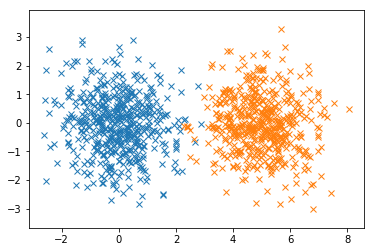

In [24]:
x,y=generateGaussArrTwoDim(2, 5, [[1,0],[0,1]], 500).T
plt.plot(x, y, 'x')
plt.axis('equal')
plt.show()

In [113]:
from sklearn import preprocessing
import numpy as np
import sys
from sklearn.metrics import accuracy_score
import pickle
from sklearn import mixture
import math

def ngram(X, gramsize):
    numele = len(X)
    minlen = len(X[0])
    maxlen = len(X[0])
    
    for i in X:
        templen = len(i)
        if(templen>maxlen):
            maxlen=templen
        if(templen<minlen):
            minlen=templen
    reqdim = maxlen - gramsize +1
    
    Y = []
    for i in X:
        tempy = []
        paddedi = i + "0"*(maxlen-len(i))
        for j in range(0,len(paddedi)-gramsize+1):
            tempy.append(paddedi[j:j+gramsize])
        if len(tempy) == 0:
            tempy = [paddedi]
        templeny = len(tempy)
        
        Y.append(tempy)
    return Y

def ngramEnforce(X, gramsize, reqdim):
    numele = len(X)
    minlen = len(X[0])
    maxlen = len(X[0])
    for i in X:
        templen = len(i)
        if(templen>maxlen):
            maxlen=templen
        if(templen<minlen):
            minlen=templen
    maxlen = reqdim + gramsize -1
    Y = []
    for i in X:
        tempy = []
        paddedi = i + "0"*(maxlen-len(i))
        for j in range(0,len(paddedi)-gramsize+1):
            tempy.append(paddedi[j:j+gramsize])
        templeny = len(tempy)
        
        Y.append(tempy)
    return np.array(Y)

def rstripfn(x):
    x = x.rstrip('\n')
    
    return x.rstrip('\n')

def getDataInString(filename):
    with open(filename) as f1:
        lst1 = map(rstripfn,f1.readlines())
    return lst1

def findngram(gramsize, lst1):
    lst1g = ngram(lst1, gramsize)

    reqdim = len(lst1g[0])
    lst1f = []
    for i in lst1g:
        lst1f.append(map(float, i))

    nplst1 = np.array(lst1f)
    return (nplst1,reqdim)

def preprocess_train(nplst1):
    lstf1 = nplst1.astype(float)
    min_max_scaler = preprocessing.MinMaxScaler()
    lstS1 = min_max_scaler.fit_transform(lstf1)
    return lstS1, min_max_scaler

def preprocess_test(nplst1, min_max_scaler):
    lstf1 = nplst1.astype(float)
    lstS1 = min_max_scaler.transform(lstf1)
    return lstS1

def trainfn(lstS1, n_compo, maxiter):
    clf = mixture.GaussianMixture(n_components=n_compo, covariance_type='full', max_iter=maxiter)
    clf.fit(lstS1)
    return clf

def findmeansigma(clf, lstS1):
    meanscore = np.mean(clf.score_samples(lstS1))
    meanvar = np.var(clf.score_samples(lstS1))
    sigma = math.sqrt(meanvar)
    return (meanscore, sigma)

def mypred(X, clf, mean, sigma):
    scores = clf.score_samples(X)
    print(scores)
    predictions = []
    for i in scores:
        print("diff is ",abs(i-mean))
        if(abs(i-mean)<=max(thres*sigma, 1.0/1e12)):
            predictions.append(1)
        else:
            predictions.append(-1)
    return predictions
def mypredSvm(X, clf):
    scores = clf.predict(X)
    return clf.predict(X)

def calcncompo(n):
    if(n>10000):
        return 100
    elif(n<60):
        return max(1, n/10)
    else:
        return 9

def areAllNumeric(l):
    l1 = map(isCharacterAscii, l)
    return all(l1)

def isCharacterAscii(str):
    try:
        float(str)
        return True
    except ValueError:
        return False

def train(filename, sstableID):
    lst1 = getDataInString(filename)
    if(not areAllNumeric(lst1)):
        print("returning cause key is not numeric")
        return
    if(len(lst1) == 1):
        print('returning cause num key is 1')
        return
    nplst1, reqdim = findngram(gramsize, lst1)
    lstS1, min_max_scaler = preprocess_train(nplst1)
    n_compo = calcncompo(len(lst1))
    clf = trainfn(lstS1, n_compo, maxiter)
    mean, sigma = findmeansigma(clf, lstS1)
    models[str(sstableID)] = (clf, mean, sigma, reqdim, min_max_scaler)
    print('training done with sstableid - ', sstableID)
    return

def trainIndi(nplst1, sstableID,n_compo):
#     lst1 = getDataInString(filename)
#     if(not areAllNumeric(lst1)):
#         print("returning cause key is not numeric")
#         return
#     if(len(lst1) == 1):
#         print('returning cause num key is 1')
#         return
#     nplst1, reqdim = findngram(gramsize, lst1)
#     print("prev mean was ", np.mean(nplst1.transpose()))
#     print("prev var was ", np.var(nplst1.transpose()))
#     lstS1, min_max_scaler = preprocess_train(nplst1)
    print("passed mean was ",np.mean(nplst1.transpose()))
    print("passed sigma was ",np.var(nplst1.transpose()))
#     n_compo = calcncompo(len(lst1))
    clf = trainfn(nplst1, n_compo, maxiter)
    print("found means ")
    print(np.sort(clf.means_.transpose()[0]))
    print("cov matrix ")
    print(clf.covariances_)
    print("weights :")
    print(clf.weights_)
    mean, sigma = findmeansigma(clf, nplst1)
    print("mean is ",str(mean))
    print("sigma is ", str(sigma))
    reqdim = len(nplst1[0])
    models[str(sstableID)] = (clf, mean, sigma, reqdim)
    print('training done with sstableid - ', sstableID)
    return

def trainIndiSvm(nplst1, sstableID):
    print("passed mean was ",np.mean(nplst1, axis=0))
    print("passed sigma was ",np.var(nplst1, axis=0))
    clf = svm.OneClassSVM(nu=nu, kernel="rbf", gamma=gamma)
    clf.fit(nplst1)
    reqdim = len(nplst1[0])
#     print("reqdim is ",reqdim)
    models[str(sstableID)] = (clf, reqdim)
    print('training done with sstableid - ', sstableID)
    return
def test(keyPredstr, sstableID):
    if(keyPredstr == ''):
        print('returning cause string is empty')
        return 0
    if(not isCharacterAscii(keyPredstr)):
        print('returning cause not numric')
        return 0
    keyPred = [str(keyPredstr)]
    if sstableID in models:
        # sizeofmodels()
        clf, mean, sigma, reqdim, min_max_scaler = models[str(sstableID)]
        keyPredg = ngramEnforce(keyPred, gramsize, reqdim)
        keyPredS = preprocess_test(keyPredg, min_max_scaler)
        prediction = mypred(keyPredS, clf, mean, sigma)
        return prediction[0]
    else:
        print(str(sstableID), ' - sstableid not in models')
        return 0

    
def testIndi(keyPredg, sstableID):
#     if(keyPredstr == ''):
#         print('returning cause string is empty')
#         return 0
#     if(not isCharacterAscii(keyPredstr)):
#         print('returning cause not numric')
#         return 0
#     keyPred = [str(keyPredstr)]
    if str(sstableID) in models:
        # sizeofmodels()
        clf, mean, sigma, reqdim= models[str(sstableID)]
#         keyPredg = ngramEnforce(keyPred, gramsize, reqdim)
#         keyPredS = preprocess_test([keyPredg], min_max_scaler)
        prediction = mypred([keyPredg], clf, mean, sigma)
        return prediction[0]
    else:
        print(str(sstableID), ' - sstableid not in models')
        return 0
def testIndiSvm(keyPredg, sstableID):
#     if(keyPredstr == ''):
#         print('returning cause string is empty')
#         return 0
#     if(not isCharacterAscii(keyPredstr)):
#         print('returning cause not numric')
#         return 0
#     keyPred = [str(keyPredstr)]
    if str(sstableID) in models:
        # sizeofmodels()
        clf, reqdim= models[str(sstableID)]
#         keyPredg = ngramEnforce(keyPred, gramsize, reqdim)
#         keyPredS = preprocess_test([keyPredg], min_max_scaler)
        prediction = mypredSvm([keyPredg], clf)
        return prediction[0]
    else:
        print(str(sstableID), ' - sstableid not in models')
        return 0

def testIndi2(keyPredg, sstableID):
#     if(keyPredstr == ''):
#         print('returning cause string is empty')
#         return 0
#     if(not isCharacterAscii(keyPredstr)):
#         print('returning cause not numric')
#         return 0
#     keyPred = [str(keyPredstr)]
    if str(sstableID) in models:
        # sizeofmodels()
        clf, mean, sigma, reqdim= models[str(sstableID)]
#         keyPredg = ngramEnforce(keyPred, gramsize, reqdim)
#         keyPredS = preprocess_test([keyPredg], min_max_scaler)
        prediction = mypred(keyPredg, clf, mean, sigma)
        return prediction
    else:
        print(str(sstableID), ' - sstableid not in models')
        return 0
def testIndiSvm2(keyPredg, sstableID):
#     if(keyPredstr == ''):
#         print('returning cause string is empty')
#         return 0
#     if(not isCharacterAscii(keyPredstr)):
#         print('returning cause not numric')
#         return 0
#     keyPred = [str(keyPredstr)]
    if str(sstableID) in models:
        # sizeofmodels()
        clf, reqdim= models[str(sstableID)]
#         keyPredg = ngramEnforce(keyPred, gramsize, reqdim)
#         keyPredS = preprocess_test([keyPredg], min_max_scaler)
        prediction = mypredSvm(keyPredg, clf)
        return prediction
    else:
        print(str(sstableID), ' - sstableid not in models')
        return 0
def sizeofmodels():
    l = []
    for sstableID in models:
        clf, mean, sigma, reqdim, min_max_scaler = models[str(sstableID)]
        print("yo")
        print(clf)
        p = pickle.dumps(clf)
        tempsize = sys.getsizeof(p)
        # print(str(tempsize))
        # print(sys.getsizeof(p))
        print(sstableID, sys.getsizeof(p))
def sumsizeofmodels(models):
    agg =0
    for sstableID in models:
        clf, mean, sigma, reqdim= models[str(sstableID)]
        print("yo")
        print(clf)
        p = pickle.dumps(clf)
        tempsize = sys.getsizeof(p)
        agg += tempsize
        # print(str(tempsize))
        # print(sys.getsizeof(p))
        print(sstableID, sys.getsizeof(p))
    return agg
def sumsizeofmodelssvm(models):
    agg =0
    for sstableID in models:
        clf, reqdim= models[str(sstableID)]
        print("yo")
        print(clf)
        p = pickle.dumps(clf)
        tempsize = sys.getsizeof(p)
        agg += tempsize
        # print(str(tempsize))
        # print(sys.getsizeof(p))
        print(sstableID, sys.getsizeof(p))
    return agg
def sumsizeofbloom(bloomfilters):
    agg =0
    for f in bloomfilters.values():
        agg += f.num_bits
    agg = agg/8
    return agg




In [460]:
numclustersPerSStable = 5
numclustersPerSStableForTrain = numclustersPerSStable
numSstable = 10
numelePerCluster = 200
gapBetweenClusters = 1.0
clusterSigma = [[0.1,0],[0,1]]
ssTableData = {}

separator = ":"

In [461]:
gramsize = -1
maxiter = 100
models = {} # storing models based on sstable ids
nu = 0.1
gamma = 10

In [462]:
thres = -0.1
bloomfilters = {}
capacityBloom = 30000
errorRate = 0.1
skipFactor = 1

In [463]:
# Generate the data
alltemptableData = generateGaussArrTwoDim(
    numclustersPerSStable*numSstable, gapBetweenClusters, clusterSigma, numelePerCluster )
np.random.shuffle(alltemptableData)


In [464]:
for i in range(0,numSstable):
    thistableData = alltemptableData[i*numclustersPerSStable:(i+1)*numclustersPerSStable]
    ssTableData[i] = thistableData.reshape(-1,thistableData.shape[2])

In [465]:
ssTableData

{0: array([[ 3.79871019,  0.570228  ],
        [ 3.57617696, -2.78710929],
        [ 4.03561242, -0.06508804],
        ...,
        [17.15020624, -1.0166761 ],
        [17.41243851,  0.39610479],
        [16.80754836, -1.44339916]]),
 1: array([[ 4.29183580e+01,  2.76596158e-01],
        [ 4.32217022e+01,  1.12616099e+00],
        [ 4.27631065e+01, -4.31518483e-01],
        ...,
        [ 3.61667343e+01, -1.44615338e-02],
        [ 3.58704977e+01, -6.50220533e-01],
        [ 3.62139060e+01,  6.70949760e-01]]),
 2: array([[36.94906439, -0.58477888],
        [37.07209996, -2.10227107],
        [36.90057764,  0.99680713],
        ...,
        [18.07608771, -2.33487859],
        [18.44838496, -1.47132225],
        [17.54378134, -1.91315163]]),
 3: array([[ 2.09014834e+00, -1.29174712e+00],
        [ 2.42165527e+00,  1.86893480e-02],
        [ 1.93165351e+00,  4.77343362e-01],
        ...,
        [ 3.84980590e+01, -1.30939211e+00],
        [ 3.88396914e+01, -8.71695533e-01],
        [ 3.90

In [466]:
scalers = {}
for i in range(0,numSstable):
    thistableData = ssTableData[i]
    scaler = preprocessing.StandardScaler().fit(thistableData)
    scalers[i] = scaler

In [467]:
# alltemptableData


In [468]:
%%time
# train the model on generated data
for i in range(0,numSstable):
    thistableData = ssTableData[i]
    trainIndiSvm(thistableData,i)


('passed mean was ', array([2.51964151e+01, 4.24761307e-04]))
('passed sigma was ', array([198.2727942 ,   0.93364396]))
('training done with sstableid - ', 0)
('passed mean was ', array([ 2.28055490e+01, -1.86762046e-02]))
('passed sigma was ', array([226.97961433,   0.97274726]))
('training done with sstableid - ', 1)
('passed mean was ', array([22.59606618, -0.02758196]))
('passed sigma was ', array([128.67238149,   1.01216109]))
('training done with sstableid - ', 2)
('passed mean was ', array([ 3.36049963e+01, -9.40724276e-03]))
('passed sigma was ', array([279.13276458,   1.04038985]))
('training done with sstableid - ', 3)
('passed mean was ', array([2.50061140e+01, 9.11879149e-03]))
('passed sigma was ', array([158.06857041,   0.9623901 ]))
('training done with sstableid - ', 4)
('passed mean was ', array([ 1.97897130e+01, -1.73792166e-02]))
('passed sigma was ', array([179.48515825,   1.04033221]))
('training done with sstableid - ', 5)
('passed mean was ', array([13.79346365,

In [469]:
# %%time
# put into bloom filter false negatives
for i in range(0,numSstable):
    thistableData = ssTableData[i]
    thistableDataTranspose0 = thistableData.transpose()[0]
    falseNegativeAns = testIndiSvm2(thistableData, i)
#     print(falseNegativeAns)
    numFalseNeg = falseNegativeAns.tolist().count(-1)
#     newCapacity = int(capacityBloom*1.0*numFalseNeg/len(thistableData))
    newCapacity = max(numFalseNeg,1)
    print("newCapacity ",newCapacity)
    f = BloomFilter(capacity=newCapacity, error_rate=errorRate)
    for j in range(0,len(thistableData)):
        if(falseNegativeAns[j]==-1):
#             print("adding ", thistableDataTranspose0[j])
            f.add(separator.join(map(str,thistableData[j])))
    bloomfilters[i] = f

('newCapacity ', 214)
('newCapacity ', 218)
('newCapacity ', 220)
('newCapacity ', 216)
('newCapacity ', 228)
('newCapacity ', 273)
('newCapacity ', 219)
('newCapacity ', 238)
('newCapacity ', 250)
('newCapacity ', 218)


In [471]:
%%time
# create test data
# For now test data is all data
# calculate false positives for test data
truePositive_c=0
truePositive_bf=0
truePositive=0
falsePositive_c=0
falsePositive_bf=0
falsePositive=0
trueNegative=0
for i in range(0, numSstable):
    print("on sstable number ", i)
    thistableData = ssTableData[i]
    thistableDataTranspose0 = thistableData.transpose()[0]
    for elemind in range(0,len(thistableData),skipFactor):
        elem = thistableData[elemind]
        for j in range(0,numSstable):
            cAnswer = (testIndiSvm(elem,j)==1)
#             print(cAnswer)
            if not cAnswer:
                bfAnswer = separator.join(map(str,elem)) in bloomfilters[j]
                finAnswer = bfAnswer
            else:
                bfAnswer = None
                finAnswer = cAnswer
            if finAnswer:
                if(i==j):
                    #True answer true positive
                    #break because you found answer
                    truePositive+=1
                    if bfAnswer is None:
                        truePositive_c+=1
                    else:
                        truePositive_bf+=1
                    break
                else:
                    #False answer false positive
                    falsePositive+=1
                    if bfAnswer is None:
                        falsePositive_c+=1
                    else:
                        falsePositive_bf+=1
            else:
                if(i==j):
                    raise ValueEroor("not possible")
                else:
                    #True answer true negative
                    trueNegative+=1
                
        


('on sstable number ', 0)
('on sstable number ', 1)
('on sstable number ', 2)
('on sstable number ', 3)
('on sstable number ', 4)
('on sstable number ', 5)
('on sstable number ', 6)
('on sstable number ', 7)
('on sstable number ', 8)
('on sstable number ', 9)
CPU times: user 5.83 s, sys: 28.2 ms, total: 5.85 s
Wall time: 5.85 s


In [472]:
print(truePositive,falsePositive,trueNegative)

(10000, 1421, 43579)


In [473]:
print(truePositive_c,truePositive_bf,falsePositive_c,falsePositive_bf)

(7706, 2294, 810, 611)


In [474]:
fprate = falsePositive*1.0/(falsePositive+trueNegative)
print(fprate)

0.0315777777778


In [475]:
sumsizeofmodelssvm(models)

yo
OneClassSVM(cache_size=200, coef0=0.0, degree=3, gamma=10, kernel='rbf',
      max_iter=-1, nu=0.1, random_state=None, shrinking=True, tol=0.001,
      verbose=False)
('1', 33739)
yo
OneClassSVM(cache_size=200, coef0=0.0, degree=3, gamma=10, kernel='rbf',
      max_iter=-1, nu=0.1, random_state=None, shrinking=True, tol=0.001,
      verbose=False)
('0', 33464)
yo
OneClassSVM(cache_size=200, coef0=0.0, degree=3, gamma=10, kernel='rbf',
      max_iter=-1, nu=0.1, random_state=None, shrinking=True, tol=0.001,
      verbose=False)
('3', 34339)
yo
OneClassSVM(cache_size=200, coef0=0.0, degree=3, gamma=10, kernel='rbf',
      max_iter=-1, nu=0.1, random_state=None, shrinking=True, tol=0.001,
      verbose=False)
('2', 35304)
yo
OneClassSVM(cache_size=200, coef0=0.0, degree=3, gamma=10, kernel='rbf',
      max_iter=-1, nu=0.1, random_state=None, shrinking=True, tol=0.001,
      verbose=False)
('5', 41261)
yo
OneClassSVM(cache_size=200, coef0=0.0, degree=3, gamma=10, kernel='rbf',
      max

356955

In [476]:
sumsizeofbloom(bloomfilters)

2751

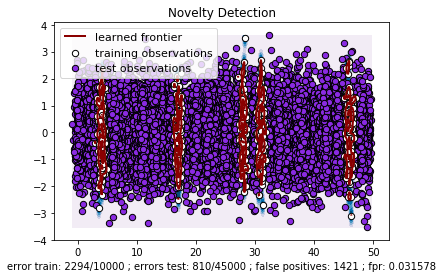

In [477]:
ssTableNumber = 0
clf = models[str(0)][0]
xx, yy = np.meshgrid(
    np.linspace(min(alltemptableData.reshape(-1,2).T[0]), max(alltemptableData.reshape(-1,2).T[0]), 500), 
    np.linspace(min(alltemptableData.reshape(-1,2).T[1]), max(alltemptableData.reshape(-1,2).T[1]), 500))
Z = clf.decision_function(np.c_[xx.ravel(),yy.ravel()])
Z = Z.reshape(xx.shape)
plt.title("Novelty Detection")
plt.contourf(xx, yy, Z, levels=np.linspace(Z.min(), 0, 7), cmap=plt.cm.PuBu)
a = plt.contour(xx, yy, Z, levels=[0], linewidths=2, colors='darkred')
plt.contourf(xx, yy, Z, levels=[0, Z.max()], colors='palevioletred')
s = 40
testData = np.array([ssTableData[i] for i in ssTableData if i!=ssTableNumber]).reshape(-1,2)
b2 = plt.scatter(testData[:, 0], testData[:, 1], c='blueviolet', s=s,
                 edgecolors='k')
b1 = plt.scatter(ssTableData[ssTableNumber][:, 0], ssTableData[ssTableNumber][:, 1], c='white', s=s, edgecolors='k')

# c = plt.scatter(X_outliers[:, 0], X_outliers[:, 0]*0+2, c='gold', s=s,
#                 edgecolors='k')
plt.axis('tight')
# plt.xlim((-5, 5))
# plt.ylim((-5, 5))
plt.legend([a.collections[0], b1, b2],
           ["learned frontier", "training observations",
            "test observations"],
           prop=matplotlib.font_manager.FontProperties(size=11))
plt.xlabel(
    "error train: %d/%d ; errors test: %d/%d ; false positives: %d ; fpr: %f"
    % (truePositive_bf, truePositive, falsePositive_c, (falsePositive + trueNegative), falsePositive, fprate))
plt.show()

In [146]:
ssTableData

{0: array([[ 1.17918663,  0.28541453],
        [ 1.35219712, -0.69764838],
        [ 0.14598823, -2.8125921 ],
        [ 1.04496899, -1.22034418]]), 1: array([[-0.52459722, -0.56873772],
        [-0.10080717, -0.12039139],
        [ 0.76330298,  0.26781113],
        [ 0.29641136, -0.99797023]])}

In [142]:
alltemptableData.reshape(-1,2).T[0]

array([ 1.17918663,  1.35219712,  0.14598823,  1.04496899, -0.52459722,
       -0.10080717,  0.76330298,  0.29641136])

In [140]:
alltemptableData

array([[[ 1.17918663,  0.28541453],
        [ 1.35219712, -0.69764838]],

       [[ 0.14598823, -2.8125921 ],
        [ 1.04496899, -1.22034418]],

       [[-0.52459722, -0.56873772],
        [-0.10080717, -0.12039139]],

       [[ 0.76330298,  0.26781113],
        [ 0.29641136, -0.99797023]]])

In [126]:
sys.getsizeof(models['0'])

72

In [127]:
def get_size(obj, seen=None):
    """Recursively finds size of objects"""
    size = sys.getsizeof(obj)
    if seen is None:
        seen = set()
    obj_id = id(obj)
    if obj_id in seen:
        return 0
    # Important mark as seen *before* entering recursion to gracefully handle
    # self-referential objects
    seen.add(obj_id)
    if isinstance(obj, dict):
        size += sum([get_size(v, seen) for v in obj.values()])
        size += sum([get_size(k, seen) for k in obj.keys()])
    elif hasattr(obj, '__dict__'):
        size += get_size(obj.__dict__, seen)
    elif hasattr(obj, '__iter__') and not isinstance(obj, (str, bytes, bytearray)):
        size += sum([get_size(i, seen) for i in obj])
    else:
        print(type(obj))
        print("cases left")
    return size

In [128]:
import sys
from types import ModuleType, FunctionType
from gc import get_referents

# Custom objects know their class.
# Function objects seem to know way too much, including modules.
# Exclude modules as well.
BLACKLIST = type, ModuleType, FunctionType


def getsize(obj):
    """sum size of object & members."""
    if isinstance(obj, BLACKLIST):
        raise TypeError('getsize() does not take argument of type: '+ str(type(obj)))
    seen_ids = set()
    size = 0
    objects = [obj]
    while objects:
        need_referents = []
        for obj in objects:
            if not isinstance(obj, BLACKLIST) and id(obj) not in seen_ids:
                seen_ids.add(id(obj))
                print(type(obj))
                print(sys.getsizeof(obj))
                size += sys.getsizeof(obj)
                print(size)
                need_referents.append(obj)
        objects = get_referents(*need_referents)
    return size

In [129]:
getsize(models['0'][0].weights_)

AttributeError: 'OneClassSVM' object has no attribute 'weights_'

In [ ]:
models['0'][0].covariances_.shape

In [ ]:
type(models['0'][0].weights_[0])

In [ ]:
tempint = 0
get_size(tempint)

In [ ]:
inspect.getmembers(models['0'][0].means_, lambda a:not(inspect.isroutine(a)))

In [ ]:
attributes = inspect.getmembers(models['0'][0], lambda a:not(inspect.isroutine(a)))

In [ ]:
[a for a in attributes if not(a[0].startswith('__') and a[0].endswith('__'))]

In [97]:
max(alltemptableData.flatten())

149.6821688911806

In [108]:
alltemptableData.reshape(-1,1)

array([[49.01943014],
       [48.85071482],
       [48.98366142],
       ...,
       [18.95085099],
       [18.94604311],
       [19.28825076]])

In [150]:
loldata = [ssTableData[i] for i in ssTableData if i!=ssTableNumber]

In [151]:
loldata[0]

array([[0.52353581],
       [0.46816131],
       [0.36282367],
       [0.64871072],
       [0.32902386],
       [0.49270312],
       [0.58351997],
       [0.65194046],
       [0.51552926],
       [0.54146075],
       [0.57311023],
       [0.52782243],
       [0.40241516],
       [0.50059871],
       [0.54584825],
       [0.5333304 ],
       [0.53657363],
       [0.41542434],
       [0.34998389],
       [0.5487896 ],
       [1.46876288],
       [1.32104549],
       [1.63565645],
       [1.52886051],
       [1.38952213],
       [1.63353662],
       [1.58255851],
       [1.67175134],
       [1.45556962],
       [1.53432124],
       [1.59951233],
       [1.41932166],
       [1.46943063],
       [1.49656045],
       [1.33728587],
       [1.2940343 ],
       [1.56756497],
       [1.51819883],
       [1.49556489],
       [1.55743974]])